In [21]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import glob
from IPython.display import display
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
from tqdm import tqdm_notebook
import random
import timm
import matplotlib.pyplot as plt
import numpy as np
import os



def plot_accuracy(train_acc, val_acc):
    plt.title('FOOD11-ResNet50')
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(train_loss, val_loss):
    plt.title('FOOD11-ResNet50')
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

In [22]:
# diretory of data
img_dir = [r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\training", 
           r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\validation"]
length_data_in_trainingSet = len(glob.glob(img_dir[0]+"\*"))


class trainDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, train_list):
        super().__init__()
        self.root_dir = root_dir
        self.train_list = train_list
        self.img_names = [self.root_dir + os.sep + item for item in self.train_list]
        self.labels = [int(item.split(os.sep)[1].split('_')[0]) for item in self.train_list]

        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                             #transforms.RandomRotation(180),
                                             transforms.ColorJitter(brightness=(0.3 if random.random()<0.5 else False),
                                                                    contrast=(0.2 if random.random()<0.5 else False),
                                                                    saturation=(0.2 if random.random()<0.5 else False),
                                                                    hue=(0.1 if random.random()<0.5 else False)),
                                             #transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=(0.15, 0), resample=False),
                                             # transforms.RandomRotation(45),
                                             # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                             # transforms.Resize((448, 448)),
                                             
                                              transforms.Resize((256, 256)),
                                              transforms.RandomCrop((224, 224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225])
                                            ])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, i):
        img = Image.open(self.img_names[i]).convert('RGB')
        return self.transform(img), self.labels[i]



class valDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, val_list):
        super().__init__()
        self.root_dir = root_dir
        self.val_list = val_list
        self.img_names = [self.root_dir + os.sep + item for item in self.val_list]
        self.labels = [int(item.split(os.sep)[1].split('_')[0]) for item in self.val_list]

        # PyTorch transforms
        self.transform = transforms.Compose([transforms.Resize((256, 256)),
                                             transforms.CenterCrop((224, 224)),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, i):
        img = Image.open(self.img_names[i]).convert('RGB')
        return self.transform(img), self.labels[i]


def random_split_train_val(train_dir, val_dir, split_ratio):
    train_names = ['training' + os.sep + item for item in os.listdir(train_dir)]
    val_names = ['validation' + os.sep + item for item in os.listdir(val_dir)]
    all_names = train_names + val_names
    nums = len(all_names)
    ratio = split_ratio
    random.shuffle(all_names)
    new_val = all_names[:round(nums * ratio)]
    new_train = all_names[round(nums * ratio):]
    return new_train, new_val

root_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\food-11"
train_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\training\\"
val_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\validation\\"
new_train, new_val = random_split_train_val(train_dir, val_dir, 0.1)
train_set = trainDataset(r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data", new_train)
print(train_set[0])
print(len(train_set))
val_set = valDataset(r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data", new_val)
print(val_set[0])
print(len(val_set))

val2_names = os.listdir(root_dir + os.sep + "evaluation" + os.sep)
val2_list = ["evaluation" + os.sep + item for item in val2_names]
val2_set = valDataset(root_dir, val2_list)

print(val2_set[0])
print(len(val2_set))
# ind = 7000
# train_data = trainDataset(img_dir)
# print(len(train_data))
# val_data = valDataset([img_dir[1]])
# img, label = train_data[ind]

(tensor([[[-1.8268, -1.9980, -1.9980,  ...,  1.2043,  1.2214,  1.2214],
         [-1.6898, -1.8782, -1.9980,  ...,  1.2385,  1.2385,  1.2385],
         [-1.7069, -1.7925, -1.9467,  ...,  1.2214,  1.2385,  1.2557],
         ...,
         [ 1.4612,  1.4612,  1.4783,  ...,  0.8961,  0.9303,  0.9646],
         [ 1.4440,  1.3413,  1.2557,  ...,  0.8789,  0.9132,  0.9474],
         [ 1.2043,  1.1015,  1.0331,  ...,  0.8789,  0.9132,  0.9303]],

        [[-1.1078, -1.3880, -1.4755,  ...,  1.2731,  1.2906,  1.3081],
         [-0.9853, -1.2654, -1.4580,  ...,  1.2731,  1.2731,  1.2906],
         [-1.0028, -1.1604, -1.3529,  ...,  1.2556,  1.2556,  1.2731],
         ...,
         [ 1.6057,  1.5882,  1.6057,  ...,  0.6078,  0.6779,  0.7654],
         [ 1.5182,  1.3782,  1.2731,  ...,  0.5378,  0.6254,  0.6604],
         [ 1.1506,  1.0630,  0.9405,  ...,  0.4678,  0.5553,  0.5903]],

        [[-1.2293, -1.4210, -1.4733,  ...,  1.8731,  1.8731,  1.9428],
         [-1.1247, -1.3164, -1.4907,  ...,  

In [23]:

batch_size = 25
test_split = 0.1

#N_test_samples = round(test_split * len(train_data))
#train_set, val_set = torch.utils.data.random_split(train_data,[len(train_data) - N_test_samples, N_test_samples])
#p = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11\evaluation"
#train_dl = torch.utils.data.DataLoader(trainDataset([img_dir[0]]), batch_size=batch_size,shuffle=True)
#val_dl = torch.utils.data.DataLoader(valDataset([img_dir[1]]), batch_size=batch_size)
#tmp = valDataset([p])
#train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
#val_dl = torch.utils.data.DataLoader(valDataset([p]), batch_size=batch_size)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
val2_dl = torch.utils.data.DataLoader(val2_set, batch_size=batch_size)


#train_set = train_data
#val_set = tmp
            
            
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

resnet50 = models.resnext50_32x4d(pretrained=True)
set_parameter_requires_grad(resnet50, True)
fc_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(fc_features, 11)

#import timm

resnet50 = timm.create_model('mixnet_xl', pretrained=True)
set_parameter_requires_grad(resnet50, True)
resnet50.classifier = nn.Linear(1536, 11)
print(resnet50)
#next(resnet50.layer4[1].conv1.parameters()).requires_grad = True
#next(resnet50.layer4[1].conv2.parameters()).requires_grad = True
#next(resnet50.layer4[1].conv3.parameters()).requires_grad = True

#next(resnet50.layer4[2].conv1.parameters()).requires_grad = True
#next(resnet50.layer4[2].conv2.parameters()).requires_grad = True
#next(resnet50.layer4[2].conv3.parameters()).requires_grad = True

#next(resnet50.layer4[0].conv1.parameters()).requires_grad = True
#next(resnet50.layer4[0].conv2.parameters()).requires_grad = True
#next(resnet50.layer4[0].conv3.parameters()).requires_grad = True

#next(resnet50.layer3[22].conv1.parameters()).requires_grad = True
#next(resnet50.layer3[22].conv2.parameters()).requires_grad = True
#next(resnet50.layer3[22].conv3.parameters()).requires_grad = True

GenEfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_pw): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): MixedConv2d(
          (0): Conv2d(20, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Conv2d(20, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn1): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_runni

)


In [24]:
torch.cuda.empty_cache()
LEARNING_RATE = 0.01
net = resnet50
net = net.cuda()
N_EPOCHS = 50


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

optimizer = torch.optim.SGD(net.parameters(),lr = LEARNING_RATE, momentum=0.9,weight_decay=1e-4) 
# MILESTONE = [1, 20, 30, 40]
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONE, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = (N_EPOCHS // 9) + 1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 7)

In [25]:
epoch_val_loss = [] 
epoch_val_acc = []
epoch_val2_loss = []
epoch_val2_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
best_val2_acc = 0
flag = 0
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    net.train()
    
      
    for i, batch in enumerate(tqdm_notebook(train_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = net(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(train_set))),
          "Training loss:", running_loss/float(len(train_dl)), "learning rate:", scheduler.get_lr()[0])
    
    scheduler.step()
    epoch_train_acc.append(running_accuracy/float(len(train_set)))
    epoch_train_loss.append(running_loss/float(len(train_set)))
    
    ### VALIDATION LOOP
    net.eval()

    running_val_loss = 0
    running_val_accuracy = 0
    
    for i, batch in enumerate(val_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = net(x)
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val_accuracy/float(len(val_set))
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(net.state_dict(), 'resnext50_imageAug.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val_loss/float(len(val_set)))
    epoch_val_loss.append(running_val_loss/len(val_set))
    epoch_val_acc.append(running_val_accuracy/len(val_set))

    
    
    running_val2_loss = 0
    running_val2_accuracy = 0
    
    for i, batch in enumerate(val2_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = net(x)
            loss = criterion(y, labels)

            running_val2_loss += loss.item()
            running_val2_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val2_accuracy/float(len(val2_set))
    if acc > best_val2_acc:
        best_val2_acc = acc
        torch.save(net.state_dict(), 'resnext50_imageAug2.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val2_loss/float(len(val2_set)))
    epoch_val2_loss.append(running_val2_loss/len(val2_set))
    epoch_val2_acc.append(running_val2_accuracy/len(val2_set))
    

#Training accuracy: 61.29% Training loss: 1.310349090006745 learning rate: 0.0004999999999999924
#Validation accuracy:78.43% Validation loss: 0.02216043197726369
#EPOCH: 1 
# LEARNING RATES TOO LOW 

#Training accuracy: 79.99% Training loss: 0.6488370027839173 learning rate: 6.698729810777737e-05
#Validation accuracy:82.36% Validation loss: 0.016642803085137037
#EPOCH: 2


#resnext50
#Training accuracy: 72.03% Training loss: 0.8572557178827432 learning rate: 0.001
#Validation accuracy:83.88% Validation loss: 0.0037515729383372706
#EPOCH: 1

#Training accuracy: 94.75% Training loss: 0.17378924873012763 learning rate: 0.001
#Validation accuracy:89.53% Validation loss: 0.0026218994257227674
#EPOCH: 14



#mixnet

#Training accuracy: 99.87% Training loss: 0.0056521773303466446 learning rate: 0.006545084971874732
#Validation accuracy:96.71% Validation loss: 0.0057580280123060035
#EPOCH: 48

EPOCH: 0


Training accuracy: 71.89% Training loss: 0.9311779392163788 learning rate: 0.01
Validation accuracy:80.90% Validation loss: 0.024848806320276477
Validation accuracy:83.93% Validation loss: 0.02266037957990458
EPOCH: 1


Training accuracy: 81.11% Training loss: 0.6019644092356238 learning rate: 0.009504844339512096
Validation accuracy:83.46% Validation loss: 0.02209740464848683
Validation accuracy:85.21% Validation loss: 0.019767612103102346
EPOCH: 2


KeyboardInterrupt: 

In [ ]:
batch_size = 25
#Restarting training at the best validation accuracy epoch , with different scheduler and learning rates 
# mixnet best accuracy for pretraining 96.79%
# restart with again cosine and after this one output the best model we will continue last training with multistep lr

restart_training = timm.create_model('mixnet_xl', pretrained=True)
restart_training.classifier = nn.Linear(1536, 11)
restart_training.load_state_dict(torch.load('model_mixnet_val2.pkl'))

root_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\food-11\evaluation\\"
train_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\training\\"
val_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\food-11\validation\\"
new_train, new_val = random_split_train_val(root_dir, val_dir, 0.1)
train_set = trainDataset(r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\food-11", new_train)
print(train_set[0])
print(len(train_set))
val_set = valDataset(r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data", new_val)
print(val_set[0])
print(len(val_set))





train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
val2_dl = torch.utils.data.DataLoader(val2_set, batch_size=batch_size)

torch.cuda.empty_cache()
LEARNING_RATE = 0.001
restart_training.cuda()


N_EPOCHS = 50


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

optimizer = torch.optim.SGD(restart_training.parameters(),lr = LEARNING_RATE, momentum=0.9,weight_decay=1e-4) 
MILESTONE = [1, 20, 30, 40]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONE, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = (N_EPOCHS // 9) + 1)



In [ ]:
epoch_val_loss = [] 
epoch_val_acc = []
epoch_val2_loss = []
epoch_val2_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
best_val2_acc = 0
flag = 0
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    restart_training.train()
    
      
    for i, batch in enumerate(tqdm_notebook(train_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = restart_training(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(train_set))),
          "Training loss:", running_loss/float(len(train_dl)), "learning rate:", scheduler.get_lr()[0])
    
    scheduler.step()
    epoch_train_acc.append(running_accuracy/float(len(train_set)))
    epoch_train_loss.append(running_loss/float(len(train_set)))
    
    ### VALIDATION LOOP
    restart_training.eval()

    running_val_loss = 0
    running_val_accuracy = 0
    
    for i, batch in enumerate(val_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = restart_training(x)
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val_accuracy/float(len(val_set))
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(restart_training.state_dict(), 'model_mixnet_restart2.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val_loss/float(len(val_set)))
    epoch_val_loss.append(running_val_loss/len(val_set))
    epoch_val_acc.append(running_val_accuracy/len(val_set))

    
    
    running_val2_loss = 0
    running_val2_accuracy = 0
    
    for i, batch in enumerate(val2_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = restart_training(x)
            loss = criterion(y, labels)

            running_val2_loss += loss.item()
            running_val2_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val2_accuracy/float(len(val2_set))
    if acc > best_val2_acc:
        best_val2_acc = acc
        torch.save(restart_training.state_dict(), 'model_mixnet_val2_restart2.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val2_loss/float(len(val2_set)))
    epoch_val2_loss.append(running_val2_loss/len(val2_set))
    epoch_val2_acc.append(running_val2_accuracy/len(val2_set))
    

In [4]:
restart_training = timm.create_model('mixnet_xl', pretrained=True)
restart_training.classifier = nn.Linear(1536, 11)
restart_training.load_state_dict(torch.load('model_mixnet.pkl'))



torch.cuda.empty_cache()
LEARNING_RATE = 0.001
restart_training.cuda()


N_EPOCHS = 50

batch_size = 25
test_split = 0.1

N_test_samples = round(test_split * len(train_data))
train_set, val_set = torch.utils.data.random_split(train_data,[len(train_data) - N_test_samples, N_test_samples])

train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size)

p = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11\evaluation"
tmp = valDataset([p])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(valDataset([p]), batch_size=batch_size)


train_set = train_data
val_set = tmp

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(restart_training.parameters(),lr = LEARNING_RATE, momentum=0.9,weight_decay=1e-4) 

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 5)

In [5]:
epoch_val_loss = [] 
epoch_val_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
flag = 0
N_EPOCHS = 50
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    restart_training.train()
    
      
    for i, batch in enumerate(tqdm_notebook(train_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = restart_training(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(train_set))),
          "Training loss:", running_loss/float(len(train_dl)), "learning rate:", scheduler.get_lr()[0])
    
    scheduler.step()
    epoch_train_acc.append(running_accuracy/float(len(train_set)))
    epoch_train_loss.append(running_loss/float(len(train_set)))
    
    ### VALIDATION LOOP
    restart_training.eval()

    running_val_loss = 0
    running_val_accuracy = 0
    
    for i, batch in enumerate(val_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = restart_training(x)
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val_accuracy/float(len(val_set))
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(restart_training.state_dict(), 'model_mixnet_restart1.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val_loss/float(len(val_set)))
    epoch_val_loss.append(running_val_loss/len(val_set))
    epoch_val_acc.append(running_val_accuracy/len(val_set))

EPOCH: 0



Training accuracy: 99.53% Training loss: 0.017840567157789845 learning rate: 0.001
Validation accuracy:99.85% Validation loss: 0.00021236590418309898
EPOCH: 1



Training accuracy: 99.57% Training loss: 0.017373887183357833 learning rate: 0.0009045084971874737
Validation accuracy:99.92% Validation loss: 0.00016884828118530375
EPOCH: 2



Training accuracy: 99.58% Training loss: 0.015941037162442086 learning rate: 0.0006545084971874737
Validation accuracy:99.85% Validation loss: 0.0002641361776154656
EPOCH: 3


KeyboardInterrupt: 

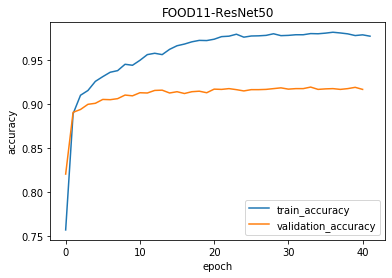

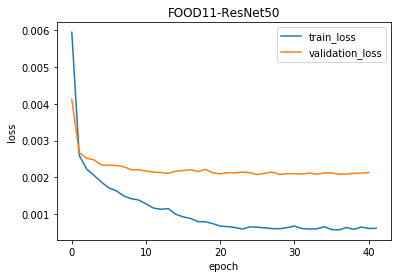

In [21]:
plot_accuracy(epoch_train_acc, epoch_val_acc) 
plot_loss(epoch_train_loss, epoch_val_loss)

In [5]:

mixnet = timm.create_model('mixnet_xl', pretrained=True)
mixnet.classifier = nn.Linear(1536, 11)
mixnet.load_state_dict(torch.load("model_mixnet_val2_restart2.pkl"))
mixnet.cuda()
mixnet.eval()
running_test_accuracy = 0
for i, batch in enumerate(val2_dl):
    with torch.no_grad():
        x = batch[0]
        labels = batch[1]
        x = x.cuda()
        x = x.cuda()
        labels = labels.cuda()
        y = mixnet(x)
        running_test_accuracy += (y.max(1)[1] == labels).sum().item()
print("Test accuracy:{:.2f}%".format(100* running_test_accuracy/float(len(val_set))))

Test accuracy:478.17%


In [37]:
# diretory of data
batch_size = 32
res_img_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\food-11\evaluation"
submission = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\kaggle_evaluation"
res_img_dir2 = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\training"
class testDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        super().__init__()
        self.img_dir = img_dir
        # use glob to get all image names
        self.img_names = [x.rsplit("\\")[-1] for x in glob.glob(img_dir + "\*") ]
        
        # PyTorch transforms
        self.transform = transforms.Compose([#transforms.RandomHorizontalFlip(p=0.5),
                                             #transforms.RandomRotation(180),
                                             #transforms.ColorJitter(),
                                             # transforms.RandomRotation(45),
                                             # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                                 transforms.Resize((256, 256)),
                                             transforms.CenterCrop((224, 224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                            ])
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, i):
        return self._read_img(i)

    def _read_img(self, i):
        img = Image.open(self.img_dir + "\\" + self.img_names[i])
        return self.transform(img), self.img_names[i]
res_test_dataset = testDataset(submission)
test_dl = torch.utils.data.DataLoader(res_test_dataset, batch_size=batch_size)

In [72]:
net.load_state_dict(torch.load("benchmark_model_resNext102.pkl"))

import pandas as pd
import numpy as np
net.eval()

res_Id = []
res_label = []

for i, batch in enumerate(test_dl):
    with torch.no_grad():
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = net(x)
        
        res_Id.append(x)
        res_label.append(y)

df = pd.DataFrame
df["Id"] = pd.Series(res_Id)
df["Category"] = pd.Series(res_label)
df.to_csv("submission_pandas.csv")



In [38]:
import pandas as pd
import numpy as np
import torchvision.models as models
#batch_size=25
#res_test_dataset = testDataset(res_img_dir)
#test_dl = torch.utils.data.DataLoader(res_test_dataset, batch_size=batch_size)
#inception = models.inception_v3(pretrained=False,aux_logits=False)
#inception.fc = nn.Linear(2048, 11)
pre_state_dict = torch.load("benchmark_model_densenet_params (1).pkl", map_location="cpu")


#inception = models.resnext101_32x8d(pretrained=False)
#fc_features = inception.fc.in_features
#inception.fc = nn.Linear(fc_features, 11)
#inception.load_state_dict(pre_state_dict)
#inception.eval()
#inception.cuda()

mixnet = timm.create_model('mixnet_xl', pretrained=False)
mixnet.classifier = nn.Linear(1536, 11)
mixnet.load_state_dict(torch.load("model_mixnet_val2.pkl"))
mixnet.cuda()
mixnet.eval()

with open('sample_submission.csv', "w") as f:
    f.write("Id,Category\n")
    for i, batch in enumerate(test_dl):
        with torch.no_grad():
            #x = torch.cat([res_test_dataset[i][0].unsqueeze(0) for _ in range(20)], 0)
            x = batch[0]
            filename = batch[1]
            x = x.cuda()
            y = mixnet(x)
            pred = y.max(1)[1]
            print(len(pred))
            for j in range(len(pred)):
                f.write("{}, {:d}\n".format((filename[j].split("."))[0], (pred[j])))



32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19


In [29]:
import pandas as pd
import numpy as np
import torchvision.models as models
#batch_size=25
#res_test_dataset = testDataset(res_img_dir)
#test_dl = torch.utils.data.DataLoader(res_test_dataset, batch_size=batch_size)
#inception = models.inception_v3(pretrained=False,aux_logits=False)
#inception.fc = nn.Linear(2048, 11)
pre_state_dict = torch.load("benchmark_model_densenet_params (1).pkl", map_location="cpu")


#inception = models.resnext101_32x8d(pretrained=False)
#fc_features = inception.fc.in_features
#inception.fc = nn.Linear(fc_features, 11)
#inception.load_state_dict(pre_state_dict)
#inception.eval()
#inception.cuda()

mixnet = timm.create_model('mixnet_xl', pretrained=False)
mixnet.classifier = nn.Linear(1536, 11)
mixnet.load_state_dict(torch.load("model_mixnet_val2.pkl"))
mixnet.cuda()
mixnet.eval()

with open('special2_sample_submission.csv', "w") as f:
    f.write("Id,Category\n")
    for i, batch in enumerate(test_dl):
        with torch.no_grad():
            #x = torch.cat([res_test_dataset[i][0].unsqueeze(0) for _ in range(20)], 0)
            x = batch[0]
            filename = batch[1]
            x = x.cuda()
            y = mixnet(x)
            pred = y.max(1)[1]
            print(len(pred))
            for j in range(len(pred)):
                if str(pred[j].tolist()) != str(filename[j].split(".")[0].split("_")[0]):
                    f.write("{}, {:d}, {}\n".format((filename[j].split("."))[0], (pred[j]),(filename[j])))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19


In [8]:
#ensemble voting , resnet101 , mixnet, efficienNet , inception
# each one has been trained before 
#For resnet
import timm
from collections import Counter

res_img_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11\evaluation"
res_test_dataset = testDataset(res_img_dir)
test_dl = torch.utils.data.DataLoader(res_test_dataset, batch_size=batch_size)

resnet101 = models.resnext101_32x8d(pretrained=False)

set_parameter_requires_grad(resnet101, True)
fc_features = resnet101.fc.in_features
resnet101.fc = nn.Linear(fc_features, 11)
resnet101.load_state_dict(torch.load("benchmark_model_densenet_params (1).pkl"))
resnet101.cuda()
resnet101.eval()
#for Mixnet 
mixnet = timm.create_model('mixnet_xl', pretrained=True)
mixnet.classifier = nn.Linear(1536, 11)
mixnet.load_state_dict(torch.load("model_mixnet.pkl"))
mixnet.cuda()
mixnet.eval()

#for inception
inception = models.inception_v3(pretrained=True, aux_logits=False)
inception.fc = nn.Linear(2048, 11)
inception.load_state_dict(torch.load("inceptionV3_epoch_16_model.pth"))
inception.cuda()
inception.eval()
#for efficientNet
#model = EfficientNet.from_pretrained(model_name='efficientnet-b5', num_classes=11)
#mixnet.classifier = nn.Linear(1536, 11)
#mixnet.load_state_dict(torch.load("mixnet.pkl"))
#mixnet.cuda()
# Id  Category



AttributeError: 'list' object has no attribute 'resnext101_32x8d'

In [24]:
models = [inception,mixnet,resnet101]
with open('voting_model_submission.csv', "w") as f:
    f.write("Id,Category\n")
    for i, batch in enumerate(test_dl):
        with torch.no_grad():
            x = batch[0]
            filename = batch[1]
            x = x.cuda()
            y_models = [model(x) for model in models]
            pred_models = [y.max(1)[1].tolist() for y in y_models]
            default = 1
            #print(pred_models)
            for j in range(len(pred_models[1])):
                res = {i:pred_models[i][j] for i in range(3)}
                tmp = list(res.values())
                tmp = [e for e in tmp]
                if len(set(tmp)) == len(models):
                    print(set(tmp))
                    f.write("{}, {:d}\n".format((filename[j].split("."))[0], (res[default][j])))
                else:
                    vote = Counter()
                    for key,items in res.items():
                        vote[items] += 1
                    vote_res = vote.most_common(1)
                    f.write("{}, {:d}\n".format((filename[j].split("."))[0], (vote_res[0][0])))

In [36]:
df = pd.read_csv("sample_submission.csv")
Ids = df["Id"].values
Cat = df["Category"].values

Ids = [int(e.split("_")[0]) for e in Ids]
Cat = [int(e) for e in Cat]
count = 0 
for i in range(len(Ids)):
    if Cat[i] != Ids[i]:
        count+=1
print(count)

102


In [ ]:

class FeaturesDataset(Dataset):
    
    def __init__(self,f1,f2,f3,labellst):
        self.feature1 = f1
        self.feature2 = f2
        self.feature3 = f3
        self.labellst = labellst
    
    def __getitem__(self,index)
